In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/willcline/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
path = "../../data/News_Category_Dataset_v2.json"

In [3]:
df = pd.read_json(path,lines=True)

In [4]:
df.head(2)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26


In [5]:
df['all_words'] = df['headline'] + "; " + df['short_description']

In [6]:
df['category'] = df['category'].replace(['CULTURE & ARTS'],'ARTS & CULTURE')

In [8]:
df.drop(['link', 'date'], axis=1, inplace=True)

In [9]:
df.head(2)

,category,headline,authors,short_description,all_words
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...


In [10]:
value_counts = round(df.category.value_counts(normalize=True)*100,2)

## By categories

In [11]:
#gets cat df, X, and y
def get_cat(cat, df):
    cat_df = df[df['category']==cat]
    cat_X = df.drop('category', axis=1)
    cat_y = df.category
    return cat_df, cat_X, cat_y

In [12]:
crime_df, crime_X, crime_y = get_cat('CRIME', df)

## Cleans, Lemmatizes, Tokenizes each Category and puts them in Dictionary. Dictionary is Pickled and function call is commented out so it doesn't load every time

In [87]:
def cat_eda(df):
    category_list = df['category'].value_counts().index.tolist()
    
    cat_df_dict = {}
    for category in category_list:
        cat_df, cat_X, cat_y = get_cat(category, df)
        cat_df['lower_desc'] = cat_df['headline'].apply(lambda x: " ".join(x.lower() for x in x.split()))
        cat_df['lower_desc'] = cat_df['lower_desc'].str.replace('[^\w\s]','')
        #stopword gathering and removal
        stop = stopwords.words('english')
        cat_df['lower_desc'] = cat_df['lower_desc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        desc_str = ' '.join(cat_df['lower_desc'].tolist())
        tokens = nltk.word_tokenize(desc_str) #tokenizing
        #lemmatize after tokenizing
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
        tokens = nltk.word_tokenize(lemmatized_tokens)
        
#         tfidf_vect = TfidfVectorizer(analyzer=tokens)
#         X_tfidf = tfidf_vect.fit_transform(df[category])
        fdist_pos = nltk.FreqDist(tokens)
        top_100_words = fdist_pos.most_common(100)
        top_words_df = pd.DataFrame(top_100_words, columns = ('word', 'count'))
        
        print(category)
        cat_df_dict[category] = top_words_df
    return cat_df_dict
#         print(tfidf_vect)
#         print(X_tfidf) 

In [113]:
# cat_df_dict = cat_eda(df)

# with open('cat_df_dict.pickle', 'wb') as handle:
#     pickle.dump(cat_df_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [114]:
with open('cat_df_dict.pickle', 'rb') as handle:
    cat_df_dict = pickle.load(handle)

### Print the top words for any category by changin "cat" variable in next line

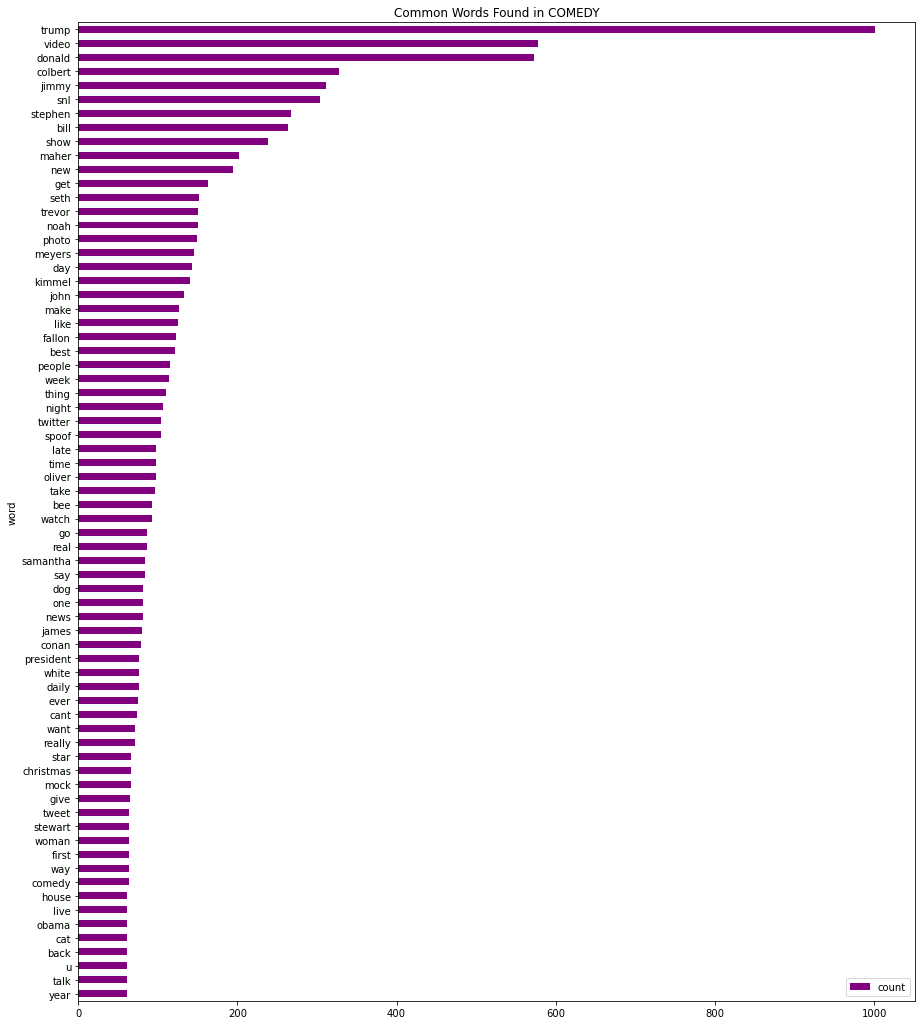

In [133]:
cat = "COMEDY"
fig, ax = plt.subplots(figsize=(15,18))
cat_top = cat_df_dict[cat].sort_values(by='count')[30:]
cat_top.plot.barh(x='word',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title(f"Common Words Found in {cat}")

plt.show()

### Pos tagging

In [23]:
tokens_pos = nltk.pos_tag(tokens)
pos_df = pd.DataFrame(tokens_pos, columns = ('word','POS'))
pos_sum = pos_df.groupby('POS', as_index=False).count() # group by POS tags
pos_sum_df = pos_sum.sort_values(['word'], ascending=[False]) # in descending order of number of words per tag

In [24]:
#getting just the nouns
filtered_pos = [ ]
for one in tokens_pos:
    if one[1] == 'NN' or one[1] == 'NNS' or one[1] == 'NNP' or one[1] == 'NNPS':
        filtered_pos.append(one)
print (len(filtered_pos))

693120


In [137]:
#the 100 most common nouns
fdist_pos = nltk.FreqDist(filtered_pos)
top_100_words = fdist_pos.most_common(100)
# print(top_100_words)

In [135]:
top_words_df = pd.DataFrame(top_100_words, columns = ('pos','count'))
top_words_df['Word'] = top_words_df['pos'].apply(lambda x: x[0]) # split the tuple of POS
top_words_df

,pos,count,Word
0,"(photos, NNS)",7056,photos
1,"(trump, NN)",6351,trump
2,"(day, NN)",4417,day
3,"(video, NN)",4220,video
4,"(women, NNS)",2845,women
...,...,...,...
95,"(dress, NN)",746,dress
96,"(moms, NNS)",742,moms
97,"(letter, NN)",738,letter
98,"(twitter, NN)",736,twitter


In [27]:
fig, ax = plt.subplots(figsize=(15,18))
top_words_df.sort_values(by='count').plot.barh(x='Word',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in DS Job Descriptions(Without Stop Words)")

plt.show()

NameError: name 'plt' is not defined